In [ ]:
! pip install transformers
! pip install datasets

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import torch
from tqdm import tqdm
import nltk
import random
import seaborn as sns
import json
from termcolor import colored

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from torchtext.vocab import vocab, FastText
from nltk.tokenize import TweetTokenizer
from transformers import AutoTokenizer, BertModel
from torch.utils.data import DataLoader
args = {'bsize': 64}

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
    print('DEVICE = ', torch.cuda.get_device_name(0) )
else:
    device = 'cpu'
    print('DEVICE = ', 'CPU')

DEVICE =  Tesla P100-PCIE-16GB


# Data exploration and preprocessing

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=125EfUNkfDxolMSOAazmP9xLeVtvNgC2R'
reviews = pd.read_csv(url)
reviews = reviews[['business_id','text','useful','stars']]

In the reduced dataset, there is 1 millions reviews (7 millions initially). Lets firstlook at the repartition of reviews per business. We don't want to have some business with only few review as it will be difficult to evaluate the usefulness of the review.

In [ ]:
nbr_reviews = reviews[['business_id','text']].groupby('business_id').count()

In [ ]:
print('the minimal number of review per business is',nbr_reviews['text'].min())
print('the minimal number of review per business is', nbr_reviews['text'].max())

the minimal number of review per business is 1
the minimal number of review per business is 1104


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa02a5e9550>]],
      dtype=object)

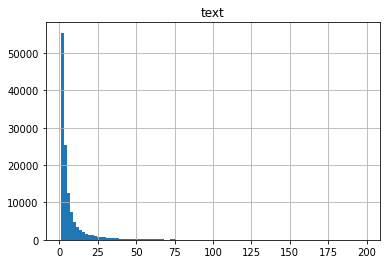

In [ ]:
nbr_reviews[nbr_reviews['text']< 200].hist('text', bins = 100)

As we see, there is a number of business with only few reviews, we will have to remove them. Now lets look at the repartition of the maximum number of useful tag for reviews per business. It will help us to construct the rule of usefulness

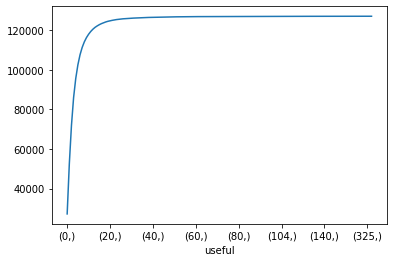

In [ ]:
nbr_useful = reviews[['business_id','useful']].groupby('business_id').max()
nbr_useful.value_counts().sort_index().cumsum().plot()

We see that the usefull tags are generally low. There is only few reviews that are considered by a great number of people as usefull. We want our model to filter all the reviews without interest so we will fix the threshold high

Now we can start preprocessing our data

In [ ]:
# here we load the business dataset to get the business categories
url = 'https://drive.google.com/uc?export=download&id=1DYT-KzhueQSZ_ITZAlghq0gLjzG6MZw1'
business = pd.read_csv( ) 
business = business[['business_id','categories']].dropna()
business['categories'] = business['categories'].transform(lambda x : x.split(', '))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
reviews = reviews.merge((nbr_useful*2/3), 'left', on = 'business_id', copy = False) # threshold of usefulness
reviews = reviews.merge(business, 'left', on = 'business_id', copy = False)
reviews = reviews.merge(nbr_reviews[nbr_reviews['text']>=10], 'left', on = 'business_id', copy = False) #filter business with less than 10 reviews
reviews['useful'] = reviews['useful_x']>reviews['useful_y'] # create the useful label using the threshold computed before
reviews = reviews.dropna(axis = 0)

# in the following, we sample 5 reviews per business
reviews['number'] = 1
data = reviews[['business_id','number']].groupby('business_id').cumsum()
reviews = reviews[data['number']<=5]


reviews = reviews[['text_x','stars','categories','useful']]
reviews.columns = ['text','stars','categories','useful']
del business

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now we want to remove the categories that are under represented in our dataset. We will keep only the top 140 categories most represented and show the repartition.

In [ ]:
categ = defaultdict(int)
for _ , row in reviews.iterrows():
    categories = row['categories']
    for elem in categories : 
        categ[elem]+=1
categ = dict(sorted(categ.items(), key=lambda item: item[1], reverse=True)[:140])
print('in our dataset, there is',len(categ),'number of categories')

in our dataset, there is 140 number of categories


<function matplotlib.pyplot.show>

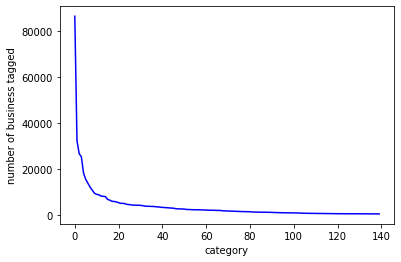

In [ ]:
plt.plot( list(categ.values()), color='blue')
plt.xlabel('category')
plt.ylabel('number of business tagged')
plt.show

Now lets look at the repartition of stars rating

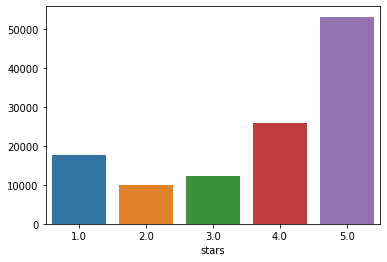

In [ ]:
stars = reviews.groupby('stars').count()['useful'].to_dict()
sns.barplot(x=list(stars.keys()),y=list(stars.values()))
plt.xlabel('stars')
plt.show()

In [ ]:
x = list(range(len(categ)))
random.shuffle(x)
map_categories = dict(zip(categ.keys(),x))

replace = []

reviews['stars'] = reviews['stars']-1  # stars label (0,1,2,3,4)
reviews['useful'] = 1 * reviews['useful'] # useful label (0,1)

# categories label [0,0,..,0,1,0,..]
def replace(x):
  ind = []
  for elem in x : 
    if elem in map_categories:
        ind.append(map_categories[elem])
  res = np.zeros(len(categ))
  res[ind] = 1
  return(np.array(res))

reviews['categories'] = reviews['categories'].transform(replace)
nbr_categ = reviews['categories'].apply(np.sum)
print("the mean number of categories per business is ", nbr_categ.mean())
reviews = reviews[nbr_categ>0] # we keep the business with categories in the 140top categories

the mean number of categories per business is  4.56142050720364


In [ ]:
sort = sorted(map_categories.items(), key=lambda item: item[1])
unmap_categories = []
for elem in sort:
    unmap_categories.append(elem[0])

In [ ]:
reviews

,text,stars,categories,useful
0,Best hotpot ever! Pre-covid I came here every ...,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,I'm willing to admit I eat here once a week. I...,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0
4,Authentic Thai Food!!! Best I've had in a long...,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0
6,"The hummus is delicious! Friendly, fast, good ...",4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
8,Ok well my wife and I had lunch at the Honu . ...,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...
861553,Who would think the best burritos/tortas in th...,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0
865913,Favorite place to order from! Sushi is very co...,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
870399,Literally the worst. Me and my friends got ch...,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0
876648,Not as much things to do as we anticipated. Wh...,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


Lets look at the repartition of word in our reviews

In [ ]:
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

tokenizer = RegexpTokenizer(r'\w+')

word_counter=defaultdict(int)
word_len=[]
text_len=[]

for review in tqdm(reviews.iterrows()):
  text = review[1]["text"]

  nb_characters=len(text)-text.count(" ")
  word_len.append(nb_characters)
  tokenized_article_text= tokenizer.tokenize(text)
  text_len.append(len(tokenized_article_text))

  for word in tokenized_article_text:
      word_counter[word]+=1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


118550it [00:12, 9736.92it/s]


In [ ]:
sorted_word=sorted(word_counter, key=word_counter.get, reverse=True)
sorted_word_dict={word:word_counter[word] for word in sorted_word}
top_words=sorted_word[:15]
top_dict={word:word_counter[word] for word in top_words}
print(top_dict.keys())

dict_keys(['the', 'and', 'I', 'a', 'to', 'was', 'of', 'is', 'it', 'for', 'in', 'The', 'that', 'with', 'my'])


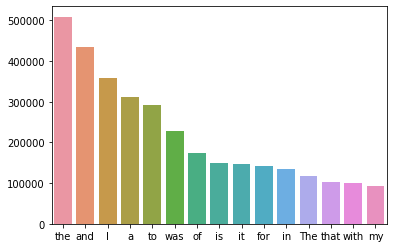

In [ ]:
x=list(top_dict.keys())
y=list(top_dict.values())
sns.barplot(x=x,y=y)
plt.show()

In [ ]:
print('the average number of words in review is :',np.mean(text_len))
print('the average number of characters in review is :',np.mean(word_len))

the average number of words in review is : 106.55568958245466
the average number of characters in review is : 460.61589202867987


Finally, lets look at the repartition of useful reviews

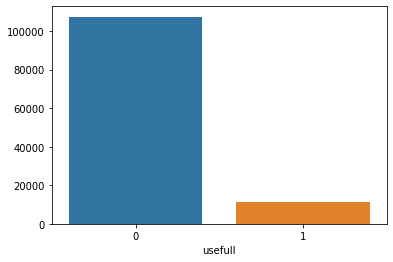

In [ ]:
useful = reviews.groupby('useful').count()['stars'].to_dict()
sns.barplot(x=list(useful.keys()),y=list(useful.values()))
plt.xlabel('usefull')
plt.show()

# Dataset preparation

In [ ]:
n = len(reviews)
train_set, val_set, test_set = np.split(reviews.sample(frac=1), [int(0.76*n),int(0.8*n)])
del reviews

In [ ]:
from torch.utils.data import Dataset
class yelp_Dataset(Dataset):

    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = {
            "text": np.array(self.data[idx]['text']),
            "label": np.array(self.data[idx][self.label])
        }
        return item

In [ ]:
fasttext = FastText(language='en')
#Bert = BertModel.from_pretrained("bert-base-uncased").to(device)

for the base model and fasttext

In [ ]:
pretrained_vocab = vocab(fasttext.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
pretrained_vocab.set_default_index(unk_index)

In [ ]:
from datasets import Dataset

tok = TweetTokenizer()

def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
    text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
    padded_text = None
    if len(text) < max_length:   
        padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
    elif len(text) > max_length: 
        padded_text = text[:max_length]
    else:                        
        padded_text = text
    return padded_text

def tokenize_all(entries, vocab_stoi):
    res = {}
    res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=50) for entry in entries['text']]
    res['stars'] = entries['stars'] 
    res['useful'] = entries['useful']
    res['categories'] = entries['categories'] 
    return res


train_dataset_fasttext = Dataset.from_pandas(train_set)
train_dataset_fasttext = train_dataset_fasttext.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched = True )

val_dataset_fasttext = Dataset.from_pandas(val_set)
val_dataset_fasttext = val_dataset_fasttext.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched = True )

test_dataset_fasttext = Dataset.from_pandas(test_set)
test_dataset_fasttext = test_dataset_fasttext.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched = True )

  0%|          | 0/91 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

for bert model

In [ ]:
"""
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

def tokenize_function(entries):
    res = {}
    res['text'] = tokenizer(entries["text"], padding="max_length", truncation=True)['input_ids']
    res['stars'] = entries['stars'] 
    res['useful'] = entries['useful']
    res['categories'] = entries['categories']
    return(res)

train_dataset_bert = Dataset.from_pandas(train_set)
train_dataset_bert = train_dataset_bert.map(tokenize_function, batched = True )

val_dataset_bert = Dataset.from_pandas(val_set)
val_dataset_bert = val_dataset_bert.map(tokenize_function, batched=True)

test_dataset_bert = Dataset.from_pandas(test_set)
test_dataset_bert = test_dataset_bert.map(tokenize_function, batched=True)
"""

'\nfrom datasets import Dataset\n\ntokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)\n\ndef tokenize_function(entries):\n    res = {}\n    res[\'text\'] = tokenizer(entries["text"], padding="max_length", truncation=True)[\'input_ids\']\n    res[\'stars\'] = entries[\'stars\'] \n    res[\'useful\'] = entries[\'useful\']\n    res[\'categories\'] = entries[\'categories\']\n    return(res)\n\ntrain_dataset_bert = Dataset.from_pandas(train_set)\ntrain_dataset_bert = train_dataset_bert.map(tokenize_function, batched = True )\n\nval_dataset_bert = Dataset.from_pandas(val_set)\nval_dataset_bert = val_dataset_bert.map(tokenize_function, batched=True)\n\ntest_dataset_bert = Dataset.from_pandas(test_set)\ntest_dataset_bert = test_dataset_bert.map(tokenize_function, batched=True)\n'

# training and inference 

In [ ]:
def train(model, loader, optimizer, ep, args, threshold = 0.5):
    model.train()
    loss_it, acc_it = list(), list()
    
    for it, batch in tqdm(enumerate(loader), desc="Epoch %s:" % (ep), total=loader.__len__()):
        
        optimizer.zero_grad()
        if model.multi :
          batch = {'text': torch.tensor(batch['text']).to(device), 'label': torch.tensor(batch['label']).type(torch.FloatTensor).to(device)}
          logits = model(batch['text'])
          loss_function = nn.BCELoss()
        else : 
          batch = {'text': torch.tensor(batch['text']).to(device), 'label': torch.tensor(batch['label']).type(torch.LongTensor).to(device)}
          logits = model(batch['text'])
          b_counter = Counter(batch['label'].detach().cpu().tolist())
          b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] ) + 0.00001
          b_weights = b_weights.to(device) 
          loss_function = nn.CrossEntropyLoss(weight=b_weights)

        loss = loss_function(logits, batch['label'])

        loss.backward()
        optimizer.step()
        loss_it.append(loss.item())

        if model.multi :
            pred = np.array(logits.cpu() > threshold, dtype=float)
            acc = (pred == np.array(batch['label'].detach().cpu())).sum()/ batch['label'].flatten().size(0)
            acc_it.append(acc)
        else : 
            _, tag_seq  = torch.max(logits, 1)

            correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
            acc = correct / batch['label'].flatten().size(0)
            acc_it.append(acc.item())

    loss_it_avg = sum(loss_it)/len(loss_it)
    acc_it_avg = sum(acc_it)/len(acc_it)
  
    print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

In [ ]:
def inference(target, loader, model, threshold = 0.5):

    model.eval()

    loss_it, acc_it, f1_it = list(), list(), list()
    preds, trues = list(), list()

    for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    
        with torch.no_grad():            
            if model.multi:
                batch = {'text': batch['text'].to(device), 'label': batch['label'].type(torch.FloatTensor).to(device)}
                loss_function = nn.BCELoss()
            else : 
                batch = {'text': batch['text'].to(device), 'label': batch['label'].type(torch.LongTensor).to(device)}
                loss_function = nn.CrossEntropyLoss()

            logits = model(batch['text'])
            loss = loss_function(logits, batch['label'])


            loss_it.append(loss.item())

            if model.multi :
                tag_seq = np.array(logits.cpu() > threshold, dtype=float)
                acc = (tag_seq == np.array(batch['label'].detach().cpu())).sum()/ batch['label'].flatten().size(0)
                acc_it.append(acc)
                preds.append(tag_seq)
                trues.append(np.array(batch['label'].cpu().detach()))
            else : 
                _, tag_seq  = torch.max(logits, 1)

                correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
                acc = correct / batch['label'].flatten().size(0)
                acc_it.append(acc.item())

                preds.extend(tag_seq.cpu().detach().tolist())
                trues.extend(batch['label'].cpu().detach().tolist())

    loss_it_avg = sum(loss_it)/len(loss_it)
    acc_it_avg = sum(acc_it)/len(acc_it)
  
    print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

    return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [ ]:
def run_epochs(model, train_loader, val_loader, args):
    args['device'] = device
    optimizer = optim.Adam(model.parameters(), lr = args['lr'])
    val_ep_losses = list()
    for ep in range(args['max_eps']):
        train(model, train_loader, optimizer, ep, args)
        trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
        val_ep_losses.append(val_loss_it_avg)
    return val_ep_losses

# MODEL

In [ ]:
vocab_size = pretrained_vocab.__len__()

class BaseModel(torch.nn.Module):
    def __init__(self, embed_dim, hidden_dim, output_dim, multi = False):
        super(BaseModel, self).__init__()
        self.multi = multi
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=False)
        
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=True)
        )
        if self.multi:
            self.activation = nn.Sigmoid()
        else : 
            self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        x  = self.embedding(x)
        x  = x.mean(1)
        logits = self.classifier(x)
        return self.activation(logits)

In [ ]:
class FastTextModel(torch.nn.Module):
    def __init__(self, embeddim, hidden_dim, output_dim, multi = False):
        super(FastTextModel, self).__init__()
        self.multi = multi

        self.embedding = torch.nn.Embedding.from_pretrained(embeddings = fasttext.vectors, freeze=True)

        
        self.classifier = nn.Sequential(
            nn.Linear(embeddim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=True)
        )
        if self.multi:
            self.activation = nn.Sigmoid()
        else : 
            self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        x  = self.embedding(x)
        x  = x.mean(1)
        logits = self.classifier(x)
        return self.activation(logits)

In [ ]:
"""
class ClassifierBERT(torch.nn.Module):
    def __init__(self, embeddim, hidden_dim, output_dim):
        super(ClassifierBERT, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(embeddim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=True),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.classifier(x[1])
        return logits
"""

'\nclass ClassifierBERT(torch.nn.Module):\n    def __init__(self, embeddim, hidden_dim, output_dim):\n        super(ClassifierBERT, self).__init__()\n        \n        self.classifier = nn.Sequential(\n            nn.Linear(embeddim, hidden_dim, bias=True),\n            nn.ReLU(),\n            nn.Linear(hidden_dim, hidden_dim, bias=True),\n            nn.ReLU(),\n            nn.Linear(hidden_dim, output_dim, bias=True),\n            nn.Softmax(dim=1)\n        )\n\n    def forward(self, x):\n        logits = self.classifier(x[1])\n        return logits\n'

# TASK 1 : number of stars prediction

In [ ]:
train_loader_stars = DataLoader(yelp_Dataset(train_dataset_fasttext, label = 'stars'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader_stars   = DataLoader(yelp_Dataset(val_dataset_fasttext, label = 'stars'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
embeddim = 50
hiddendim = 50
outputdim = 5 
args.update({'max_eps': 5, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': outputdim})

model_base_stars = BaseModel(embeddim, hiddendim, outputdim).to(device)
loss_list_val = run_epochs(model_base_stars, train_loader_stars, val_loader_stars, args)

Epoch 0::   0%|          | 0/1407 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
Epoch 0:: 100%|██████████| 1407/1407 [00:37<00:00, 37.13it/s]

Epoch 0/5 : Training : (loss 1.47602197695219) (acc 0.44867181947405826)



validation:: 100%|██████████| 74/74 [00:01<00:00, 59.82it/s]

validation : (loss 1.385703001473401) (acc 0.49472128378378377)



Epoch 1:: 100%|██████████| 1407/1407 [00:38<00:00, 37.01it/s]

Epoch 1/5 : Training : (loss 1.3982175130240868) (acc 0.5352922885572139)



validation:: 100%|██████████| 74/74 [00:01<00:00, 56.66it/s]

validation : (loss 1.3641816780373857) (acc 0.5206925675675675)



Epoch 2:: 100%|██████████| 1407/1407 [00:38<00:00, 36.76it/s]

Epoch 2/5 : Training : (loss 1.367061964569146) (acc 0.5643656716417911)



validation:: 100%|██████████| 74/74 [00:01<00:00, 57.55it/s]

validation : (loss 1.3500572459117786) (acc 0.5386402027027027)



Epoch 3:: 100%|██████████| 1407/1407 [00:37<00:00, 37.11it/s]

Epoch 3/5 : Training : (loss 1.341314907606053) (acc 0.5882862473347548)



validation:: 100%|██████████| 74/74 [00:01<00:00, 59.95it/s]

validation : (loss 1.354942569861541) (acc 0.5331503378378378)



Epoch 4:: 100%|██████████| 1407/1407 [00:37<00:00, 37.07it/s]

Epoch 4/5 : Training : (loss 1.3204497236178627) (acc 0.6077203269367448)



validation:: 100%|██████████| 74/74 [00:01<00:00, 59.04it/s]


validation : (loss 1.357475127722766) (acc 0.5333614864864865)


In [ ]:
embeddim = 300
hiddendim = 50

model_fast_stars = FastTextModel(embeddim, hiddendim, outputdim).to(device)
loss_list_val_fast_stars = run_epochs(model_fast_stars, train_loader_stars, val_loader_stars, args)

Epoch 0::   0%|          | 0/1407 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
Epoch 0:: 100%|██████████| 1407/1407 [00:21<00:00, 65.88it/s]

Epoch 0/5 : Training : (loss 1.537757750936832) (acc 0.3981987384506041)



validation:: 100%|██████████| 74/74 [00:01<00:00, 61.72it/s]

validation : (loss 1.4489648197148297) (acc 0.44130067567567566)



Epoch 1:: 100%|██████████| 1407/1407 [00:20<00:00, 68.25it/s]

Epoch 1/5 : Training : (loss 1.4936997749827479) (acc 0.4285270078180526)



validation:: 100%|██████████| 74/74 [00:01<00:00, 58.80it/s]

validation : (loss 1.4020243560945667) (acc 0.4904983108108108)



Epoch 2:: 100%|██████████| 1407/1407 [00:20<00:00, 68.00it/s]

Epoch 2/5 : Training : (loss 1.4852216813101697) (acc 0.4362895344705046)



validation:: 100%|██████████| 74/74 [00:01<00:00, 60.24it/s]

validation : (loss 1.4138790014627818) (acc 0.4719172297297297)



Epoch 3:: 100%|██████████| 1407/1407 [00:20<00:00, 67.32it/s]

Epoch 3/5 : Training : (loss 1.4820869218057662) (acc 0.4400319829424307)



validation:: 100%|██████████| 74/74 [00:01<00:00, 58.24it/s]

validation : (loss 1.4479659086949117) (acc 0.4370777027027027)



Epoch 4:: 100%|██████████| 1407/1407 [00:22<00:00, 63.51it/s]

Epoch 4/5 : Training : (loss 1.4796215524551457) (acc 0.4401874555792466)



validation:: 100%|██████████| 74/74 [00:01<00:00, 59.42it/s]

validation : (loss 1.442294264161909) (acc 0.43813344594594594)


# Task 2 : Useful

In [ ]:
train_loader_useful = DataLoader(yelp_Dataset(train_dataset_fasttext, label = 'useful'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader_useful   = DataLoader(yelp_Dataset(val_dataset_fasttext, label = 'useful'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
embeddim = 50
hiddendim = 50
outputdim = 2 
args.update({'max_eps': 5, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': outputdim})

model_base_useful = BaseModel(embeddim, hiddendim, outputdim).to(device)
loss_list_val = run_epochs(model_base_useful, train_loader_useful, val_loader_useful, args)

Epoch 0::   0%|          | 0/1407 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
Epoch 0:: 100%|██████████| 1407/1407 [00:37<00:00, 37.30it/s]

Epoch 0/5 : Training : (loss 0.6497825156862886) (acc 0.5478300461975835)



validation:: 100%|██████████| 74/74 [00:01<00:00, 60.01it/s]

validation : (loss 0.6956718515705418) (acc 0.49767736486486486)



Epoch 1:: 100%|██████████| 1407/1407 [00:37<00:00, 37.26it/s]

Epoch 1/5 : Training : (loss 0.6314130244563468) (acc 0.6103300461975835)



validation:: 100%|██████████| 74/74 [00:01<00:00, 60.50it/s]

validation : (loss 0.6542858634446118) (acc 0.6024070945945946)



Epoch 2:: 100%|██████████| 1407/1407 [00:37<00:00, 37.31it/s]

Epoch 2/5 : Training : (loss 0.6122276888896832) (acc 0.6592484008528785)



validation:: 100%|██████████| 74/74 [00:01<00:00, 58.90it/s]

validation : (loss 0.6025341757245966) (acc 0.6807432432432432)



Epoch 3:: 100%|██████████| 1407/1407 [00:37<00:00, 37.26it/s]

Epoch 3/5 : Training : (loss 0.5886426178080526) (acc 0.6966506751954513)



validation:: 100%|██████████| 74/74 [00:01<00:00, 61.67it/s]

validation : (loss 0.620562451916772) (acc 0.6701858108108109)



Epoch 4:: 100%|██████████| 1407/1407 [00:37<00:00, 37.21it/s]

Epoch 4/5 : Training : (loss 0.5625321891982249) (acc 0.7315098614072495)



validation:: 100%|██████████| 74/74 [00:01<00:00, 60.30it/s]


validation : (loss 0.5831689125782734) (acc 0.7155827702702703)


In [ ]:
embeddim = 300
hiddendim = 50

model_fast_useful = FastTextModel(embeddim, hiddendim, outputdim).to(device)
loss_list_val_fast_useful = run_epochs(model_fast_useful, train_loader_useful, val_loader_useful, args)

Epoch 0::   0%|          | 0/1407 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
Epoch 0:: 100%|██████████| 1407/1407 [00:21<00:00, 66.55it/s]

Epoch 0/5 : Training : (loss 0.6568498569087263) (acc 0.5004886282871357)



validation:: 100%|██████████| 74/74 [00:01<00:00, 58.52it/s]

validation : (loss 0.6955046992044192) (acc 0.4864864864864865)



Epoch 1:: 100%|██████████| 1407/1407 [00:20<00:00, 68.30it/s]

Epoch 1/5 : Training : (loss 0.6483347980198322) (acc 0.5534159559346127)



validation:: 100%|██████████| 74/74 [00:01<00:00, 60.59it/s]

validation : (loss 0.6286079585552216) (acc 0.6131756756756757)



Epoch 2:: 100%|██████████| 1407/1407 [00:20<00:00, 68.39it/s]

Epoch 2/5 : Training : (loss 0.6469158542520541) (acc 0.5636105188343994)



validation:: 100%|██████████| 74/74 [00:01<00:00, 60.17it/s]

validation : (loss 0.653863045814875) (acc 0.574535472972973)



Epoch 3:: 100%|██████████| 1407/1407 [00:20<00:00, 67.33it/s]

Epoch 3/5 : Training : (loss 0.6452305033517036) (acc 0.5653207178393745)



validation:: 100%|██████████| 74/74 [00:01<00:00, 60.06it/s]

validation : (loss 0.7126901455827661) (acc 0.4731841216216216)



Epoch 4:: 100%|██████████| 1407/1407 [00:20<00:00, 68.97it/s]

Epoch 4/5 : Training : (loss 0.6449291842493845) (acc 0.5669087597725657)



validation:: 100%|██████████| 74/74 [00:01<00:00, 58.62it/s]


validation : (loss 0.6793762896512006) (acc 0.5109797297297297)


# TASK 3: categories

In [ ]:
train_loader_categories = DataLoader(yelp_Dataset(train_dataset_fasttext, label = 'categories'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader_categories   = DataLoader(yelp_Dataset(val_dataset_fasttext, label = 'categories'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
embeddim = 50
hiddendim = 50
outputdim = 140
args.update({'max_eps': 5, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': outputdim})

model_base_categories = BaseModel(embeddim, hiddendim, outputdim, multi = True).to(device)
loss_list_val = run_epochs(model_base_categories, train_loader_categories, val_loader_categories, args)

Epoch 0::   0%|          | 0/1407 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
Epoch 0:: 100%|██████████| 1407/1407 [00:37<00:00, 37.29it/s]

Epoch 0/5 : Training : (loss 0.12621276016004898) (acc 0.9663998248553166)



validation:: 100%|██████████| 74/74 [00:01<00:00, 60.76it/s]

validation : (loss 0.10553377252575513) (acc 0.9713652268339764)



Epoch 1:: 100%|██████████| 1407/1407 [00:37<00:00, 37.35it/s]

Epoch 1/5 : Training : (loss 0.10103874279195396) (acc 0.9717854445882825)



validation:: 100%|██████████| 74/74 [00:01<00:00, 60.55it/s]

validation : (loss 0.0988204850739724) (acc 0.9719172297297297)



Epoch 2:: 100%|██████████| 1407/1407 [00:37<00:00, 37.35it/s]

Epoch 2/5 : Training : (loss 0.09483738703747209) (acc 0.9725982650522919)



validation:: 100%|██████████| 74/74 [00:01<00:00, 59.27it/s]

validation : (loss 0.09366327463775068) (acc 0.972739201254826)



Epoch 3:: 100%|██████████| 1407/1407 [00:37<00:00, 37.35it/s]

Epoch 3/5 : Training : (loss 0.08971162707503162) (acc 0.9735295937404818)



validation:: 100%|██████████| 74/74 [00:01<00:00, 61.19it/s]

validation : (loss 0.09034358961759387) (acc 0.9733123190154439)



Epoch 4:: 100%|██████████| 1407/1407 [00:37<00:00, 37.35it/s]

Epoch 4/5 : Training : (loss 0.08617704967996628) (acc 0.9741946358767372)



validation:: 100%|██████████| 74/74 [00:01<00:00, 61.92it/s]


validation : (loss 0.08814820284779007) (acc 0.973716517857143)


In [ ]:
embeddim = 300
hiddendim = 50

model_fast_categories = FastTextModel(embeddim, hiddendim, outputdim, multi = True).to(device)
loss_list_val = run_epochs(model_fast_categories, train_loader_categories, val_loader_categories, args)

Epoch 0::   0%|          | 0/1407 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
Epoch 0:: 100%|██████████| 1407/1407 [00:22<00:00, 63.54it/s]

Epoch 0/5 : Training : (loss 0.12554028111840276) (acc 0.9657637355315262)



validation:: 100%|██████████| 74/74 [00:01<00:00, 58.87it/s]

validation : (loss 0.1129133991293005) (acc 0.970508566602317)



Epoch 1:: 100%|██████████| 1407/1407 [00:21<00:00, 66.61it/s]

Epoch 1/5 : Training : (loss 0.11196723465980497) (acc 0.9706342331708782)



validation:: 100%|██████████| 74/74 [00:01<00:00, 60.10it/s]

validation : (loss 0.11232396094380198) (acc 0.9705161076254829)



Epoch 2:: 100%|██████████| 1407/1407 [00:21<00:00, 66.80it/s]

Epoch 2/5 : Training : (loss 0.10948335998390445) (acc 0.9708960776474765)



validation:: 100%|██████████| 74/74 [00:01<00:00, 61.83it/s]

validation : (loss 0.10828797317839958) (acc 0.9709806346525095)



Epoch 3:: 100%|██████████| 1407/1407 [00:21<00:00, 66.22it/s]

Epoch 3/5 : Training : (loss 0.10702228623454928) (acc 0.9711092972636814)



validation:: 100%|██████████| 74/74 [00:01<00:00, 62.59it/s]

validation : (loss 0.10662425450376563) (acc 0.9711043074324319)



Epoch 4:: 100%|██████████| 1407/1407 [00:21<00:00, 65.76it/s]

Epoch 4/5 : Training : (loss 0.10562150692931285) (acc 0.9711632367499243)



validation:: 100%|██████████| 74/74 [00:01<00:00, 59.34it/s]

validation : (loss 0.10537628759000753) (acc 0.971184242277992)


# Results

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve

In [ ]:
test_loader_stars = DataLoader(yelp_Dataset(test_dataset_fasttext, label = 'stars'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader_stars, model_base_stars)
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten()))

test:: 100%|██████████| 370/370 [00:05<00:00, 69.14it/s]

test : (loss 1.358165944589151) (acc 0.5336993243243243)
              precision    recall  f1-score   support

           0       0.61      0.66      0.63      3458
           1       0.27      0.39      0.32      1984
           2       0.26      0.37      0.31      2333
           3       0.39      0.42      0.40      5207
           4       0.81      0.61      0.69     10698

    accuracy                           0.53     23680
   macro avg       0.47      0.49      0.47     23680
weighted avg       0.59      0.53      0.55     23680



In [ ]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader_stars, model_fast_stars)
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten()))

test:: 100%|██████████| 370/370 [00:05<00:00, 68.86it/s]


test : (loss 1.442088779243263) (acc 0.4388091216216216)
              precision    recall  f1-score   support

           0       0.38      0.60      0.46      3455
           1       0.18      0.25      0.21      1986
           2       0.21      0.32      0.26      2333
           3       0.33      0.28      0.30      5204
           4       0.75      0.53      0.62     10702

    accuracy                           0.44     23680
   macro avg       0.37      0.39      0.37     23680
weighted avg       0.50      0.44      0.46     23680



In [ ]:
test_loader_useful = DataLoader(yelp_Dataset(test_dataset_fasttext, label = 'useful'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader_useful, model_base_useful)
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten()))

test:: 100%|██████████| 370/370 [00:05<00:00, 68.69it/s]


test : (loss 0.5825232465524931) (acc 0.7128378378378378)
              precision    recall  f1-score   support

           0       0.93      0.74      0.82     21422
           1       0.15      0.44      0.22      2258

    accuracy                           0.71     23680
   macro avg       0.54      0.59      0.52     23680
weighted avg       0.85      0.71      0.77     23680



In [ ]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader_useful, model_fast_useful)
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten()))

test:: 100%|██████████| 370/370 [00:05<00:00, 68.67it/s]


test : (loss 0.6735922784418673) (acc 0.5230996621621622)
              precision    recall  f1-score   support

           0       0.95      0.50      0.65     21425
           1       0.14      0.75      0.23      2255

    accuracy                           0.52     23680
   macro avg       0.54      0.62      0.44     23680
weighted avg       0.87      0.52      0.61     23680



In [ ]:
test_loader_categories = DataLoader(yelp_Dataset(test_dataset_fasttext, label = 'categories'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader_categories, model_base_categories)
print(classification_report(np.concatenate(trues, axis=0), np.concatenate(preds, axis = 0), target_names = unmap_categories))

test:: 100%|██████████| 370/370 [00:05<00:00, 66.82it/s]


test : (loss 0.08728417256796682) (acc 0.9741774251930511)
                           precision    recall  f1-score   support

              Food Trucks       0.00      0.00      0.00       204
            Home & Garden       0.00      0.00      0.00       264
                 Bakeries       0.00      0.00      0.00       874
                    Pizza       0.88      0.44      0.58      1790
             Beer Gardens       0.00      0.00      0.00       111
                  Mexican       0.91      0.26      0.41      1693
                     Thai       0.60      0.03      0.07       523
                    Tacos       0.00      0.00      0.00       262
                  Burgers       1.00      0.00      0.00      1588
                   Indian       0.00      0.00      0.00       356
                  Tex-Mex       0.00      0.00      0.00       330
   Food Delivery Services       0.00      0.00      0.00       233
                   French       0.00      0.00      0.00       294
  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader_categories, model_fast_categories)
print(classification_report(np.concatenate(trues, axis=0), np.concatenate(preds, axis = 0), target_names = unmap_categories))

test:: 100%|██████████| 370/370 [00:05<00:00, 66.87it/s]


test : (loss 0.10465989356508126) (acc 0.9713257118725869)
                           precision    recall  f1-score   support

              Food Trucks       0.00      0.00      0.00       204
            Home & Garden       0.00      0.00      0.00       264
                 Bakeries       0.00      0.00      0.00       874
                    Pizza       0.97      0.06      0.11      1790
             Beer Gardens       0.00      0.00      0.00       111
                  Mexican       0.00      0.00      0.00      1691
                     Thai       0.00      0.00      0.00       524
                    Tacos       0.00      0.00      0.00       262
                  Burgers       0.00      0.00      0.00      1589
                   Indian       0.00      0.00      0.00       357
                  Tex-Mex       0.00      0.00      0.00       330
   Food Delivery Services       0.00      0.00      0.00       235
                   French       0.00      0.00      0.00       296
  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BERT Try

In [ ]:
def train(model_embedding, model_classifier, loader, optimizer, ep, args, local = False):
    model_classifier.train()
    if local : 
      model_embedding.train()
    loss_it, acc_it = list(), list()
    
    for it, batch in tqdm(enumerate(loader), desc="Epoch %s:" % (ep), total=loader.__len__()):
        batch = {'text': torch.tensor(batch['text']).to(device), 'label': torch.tensor(batch['label']).type(torch.LongTensor).to(device)}
        optimizer.zero_grad()
        logits = model_classifier(model_embedding(batch['text']))

        b_counter = Counter(batch['label'].detach().cpu().tolist())
        b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
        b_weights = b_weights.to(device)

        loss_function = nn.CrossEntropyLoss(weight=b_weights)
        loss = loss_function(logits, batch['label'])

        loss.backward()
        optimizer.step()
        loss_it.append(loss.item())
        _, tag_seq  = torch.max(logits, 1)

        correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
        acc = correct / batch['label'].flatten().size(0)
        acc_it.append(acc.item())

    loss_it_avg = sum(loss_it)/len(loss_it)
    acc_it_avg = sum(acc_it)/len(acc_it)
  
    print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))



def inference(target, loader, model_embedding, model_classifier, local = False):

    model_classifier.eval()
    if local : 
      model_embedding.eval()

    loss_it, acc_it, f1_it = list(), list(), list()
    preds, trues = list(), list()

    for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    
        with torch.no_grad():
            batch = {'text': batch['text'].to(device), 'label': batch['label'].type(torch.LongTensor).to(device)}
            logits = model_classifier(model_embedding(batch['text']))
            loss_function = nn.CrossEntropyLoss()
            loss = loss_function(logits, batch['label'])

            loss_it.append(loss.item())
            _, tag_seq  = torch.max(logits, 1)

            correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
            acc = correct / batch['label'].flatten().size(0)
            acc_it.append(acc.item())

            preds.extend(tag_seq.cpu().detach().tolist())
            trues.extend(batch['label'].cpu().detach().tolist())

    loss_it_avg = sum(loss_it)/len(loss_it)
    acc_it_avg = sum(acc_it)/len(acc_it)
  
    print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

    return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it


def run_epochs(model_embedding, model_classifier, train_loader, val_loader, args):
    args['device'] = device
    optimizer = optim.Adam(model_classifier.parameters(), lr = args['lr'])
    val_ep_losses = list()
    for ep in range(args['max_eps']):
        train(model_embedding, model_classifier, train_loader, optimizer, ep, args)
        trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference(model_embedding, model_classifier, val_loader, model)
        val_ep_losses.append(val_loss_it_avg)
    return val_ep_losses



In [ ]:
train_loader_stars = DataLoader(yelp_Dataset(train_dataset_bert, label = 'stars'), batch_size=16, num_workers=2, shuffle=True, drop_last=True)
val_loader_stars   = DataLoader(yelp_Dataset(val_dataset_bert, label = 'stars'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader_stars  = DataLoader(yelp_Dataset(test_dataset_bert, label = 'stars'), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
embeddim = 768
hiddendim = 50
outputdim = 5 
args.update({'max_eps': 5, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': 5})

model_bert_stars = ClassifierBERT(embeddim, hiddendim, outputdim).to(device)
loss_list_val_bert_stars = run_epochs(Bert, model_bert_stars, train_loader_stars, val_loader_stars, args)
